In [23]:
import os, pickle, copy
os.chdir(os.path.expanduser(os.path.join("~", "Projects", "zimmer")))

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# from scipy.io import loadmat
import imp
import zimmer.io
reload(zimmer.io)
from zimmer.io import WormData, find_shared_neurons, N_worms

from sklearn.decomposition import PCA

# Come up with a set of colors
N_colors = 12
from palettable.colorbrewer.qualitative import Set3_12
colors = Set3_12.mpl_colors
cmap = Set3_12.mpl_colormap

%matplotlib inline

# Set path to work out of root directory
os.chdir(os.path.join(os.path.expanduser("~"), "Projects", "zimmer"))


results_dir = os.path.join("results", "08_22_16", "run002")

In [24]:
# Load the data
worm_datas = [WormData(i) for i in range(N_worms)]
Ns = np.array([wd.N for wd in worm_datas])
Ts = np.array([wd.T for wd in worm_datas])
Ys = [wd.dff_deriv for wd in worm_datas]

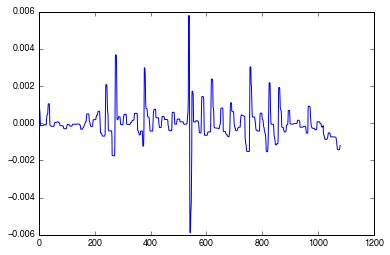

In [21]:
plt.plot(worm_datas[0].tt, Ys[0][:,0])

In [4]:
# Find the shared neurons
shared_neurons = find_shared_neurons(worm_datas)
N_shared = len(shared_neurons)
Ns_unique = Ns - N_shared

Ys_shared = []
Ys_unique = []
for wd, Y in zip(worm_datas, Ys):
    shared_indices = wd.find_neurons(shared_neurons)
    unique_indices = set(np.arange(wd.N))
    unique_indices -= set(shared_indices)
    unique_indices = list(unique_indices)
    
    Ys_shared.append(Y[:,shared_indices])
    Ys_unique.append(Y[:,unique_indices])


Potentially shared neurons:
 [None 'AIBL' 'AIBR' 'ALA' 'AVAL' 'AVAR' 'AVBL' 'AVBR' 'AVER' 'RIBL' 'RID'
 'RIML' 'RIMR' 'RIVL' 'RIVR' 'RMED' 'RMEL' 'RMER' 'SMDVR' 'VB01' 'VB02']
Found 15 truly shared neurons:
['AIBL', 'AIBR', 'ALA', 'AVAL', 'AVAR', 'AVBL', 'AVER', 'RID', 'RIML', 'RIMR', 'RMED', 'RMEL', 'RMER', 'VB01', 'VB02']


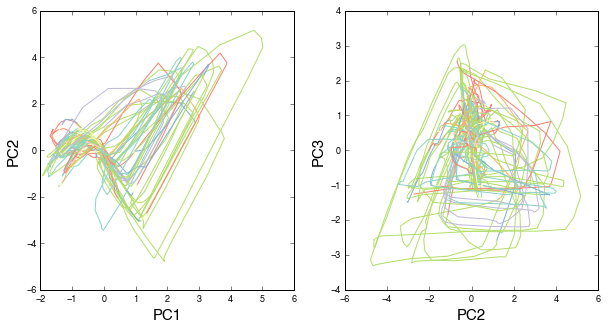

In [5]:
# Try to reproduce their plot of PC's over time
pca = PCA(n_components=3, whiten=True)
pca.fit(np.vstack(Ys_shared))
pca.explained_variance_ratio_

pca_trajs = [pca.transform(Y) for Y in Ys_shared]
pcs = pca.components_.T

plt.figure(figsize=(10,5))
zimmer_states, zimmer_cps = worm_datas[0].zimmer_states, worm_datas[0].zimmer_cps
for cp_start, cp_stop in zip(zimmer_cps[:-1], zimmer_cps[1:]):
    plt.subplot(121)
    plt.plot(pca_trajs[0][cp_start:cp_stop+1,0], 
             pca_trajs[0][cp_start:cp_stop+1,1], 
             '-', color=colors[zimmer_states[cp_start]])
    plt.subplot(122)
    plt.plot(pca_trajs[0][cp_start:cp_stop+1,1], 
             pca_trajs[0][cp_start:cp_stop+1,2], 
             '-', color=colors[zimmer_states[cp_start]])
    
plt.subplot(121)
plt.xlabel("PC1", fontsize=15)
plt.ylabel("PC2", fontsize=15)

plt.subplot(122)
plt.xlabel("PC2", fontsize=15)
plt.ylabel("PC3", fontsize=15)

# Fit an SLDS to the data from all worms


In [6]:
from pybasicbayes.distributions import AutoRegression, DiagonalRegression, Gaussian, Regression
from pybasicbayes.util.text import progprint_xrange

from pyslds.models import HMMSLDS

from pinkybrain.models import MultiEmissionWeakLimitStickyHDPHMMSLDS
from pyslds.util import get_empirical_ar_params

In [7]:
Nmax = 15          # number of latent discrete states
P = 3              # latent linear dynamics' dimension
P_in = 0           # number of input dimensions

dynamics_hypparams = \
    dict(nu_0=P+2, 
         S_0=np.eye(P), 
         M_0=np.zeros((P,P+P_in)), 
         K_0=np.eye(P+P_in), 
         affine=False)
dynamics_hypparams = get_empirical_ar_params([np.vstack(pca_trajs)[:,:P]], dynamics_hypparams)

dynamics_distns = [
    AutoRegression(
        A=np.hstack((0.99*np.eye(P), np.zeros((P,P_in)))), 
        sigma=np.eye(P),
        **dynamics_hypparams)
    for _ in range(Nmax)]

# First emission distribution handles the shared neurons
emission_distns = [
    DiagonalRegression(N_shared, P+P_in, 
                       A=np.hstack((pcs[:,:P], np.zeros((N_shared,P_in)))))
    ]
    
# Now add emission distributions for each worm's unique neurons
for Nu in Ns_unique:
    emission_distns.append(DiagonalRegression(Nu, P+P_in))

init_dynamics_distns = [
    Gaussian(nu_0=P+2, sigma_0=3.*np.eye(P), mu_0=np.zeros(P), kappa_0=0.01)
    for _ in xrange(Nmax)]

model = MultiEmissionWeakLimitStickyHDPHMMSLDS(
    init_dynamics_distns=init_dynamics_distns,
    dynamics_distns=dynamics_distns,
    emission_distns=emission_distns,
    alpha=3., gamma=3.0, kappa=1., init_state_distn='uniform')

/Users/scott/Install/pybasicbayes/pybasicbayes/util/stats.py:191: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = np.random.randn(nu,n)


In [8]:
# Add the data
for worm_index, pca_traj, Ys, Yu in zip(range(N_worms), pca_trajs, Ys_shared, Ys_unique):
    dataset = [Ys] + [None] * N_worms
    dataset[1 + worm_index] = Yu
    model.add_data(data=dataset)
    model.states_list[-1].gaussian_states = pca_traj[:,:P]
    #model.states_list[-1].resample_discrete_states()
model.resample_parameters()

In [9]:
worm_to_plot = 0

results_fname = os.path.join(results_dir, "K%d_samples.pkl" % Nmax)
if os.path.exists(results_fname):
    # Check for existing results
    with open(results_fname, "r") as f:
        model, lls, stateseq_smpls = pickle.load(f)
        N_samples = len(stateseq_smpls)
else:
    # Fit the model with MCMC
    def update(model):
        model.resample_model()
        ll = model.log_likelihood()
        stateseq = model.stateseqs[worm_to_plot].copy()
        return ll, stateseq
    
    N_samples = 500
    smpls = [update(model) for itr in progprint_xrange(N_samples)]
    lls, stateseq_smpls = map(np.array, zip(*smpls))
    with open(results_fname, "wb") as f:
        pickle.dump((model, lls, stateseq_smpls), f, protocol=-1)



.........................  [  25/500,    0.46sec avg, ETA 03:39 ]
.........................  [  50/500,    0.48sec avg, ETA 03:35 ]
.........................  [  75/500,    0.46sec avg, ETA 03:17 ]
.........................  [ 100/500,    0.47sec avg, ETA 03:07 ]
.........................  [ 125/500,    0.48sec avg, ETA 03:01 ]
.........................  [ 150/500,    0.49sec avg, ETA 02:50 ]
.........................  [ 175/500,    0.49sec avg, ETA 02:39 ]
.........................  [ 200/500,    0.50sec avg, ETA 02:31 ]
.........................  [ 225/500,    0.50sec avg, ETA 02:18 ]
.........................  [ 250/500,    0.51sec avg, ETA 02:08 ]
.........................  [ 275/500,    0.51sec avg, ETA 01:54 ]
.........................  [ 300/500,    0.51sec avg, ETA 01:41 ]
.........................  [ 325/500,    0.50sec avg, ETA 01:28 ]
.........................  [ 350/500,    0.50sec avg, ETA 01:15 ]
.........................  [ 375/500,    0.50sec avg, ETA 01:02 ]
..........

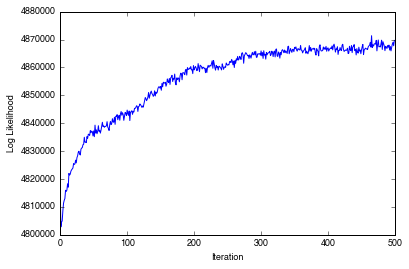

In [10]:
# Plot the log likelihood vs iteration. 
plt.figure()
plt.plot(lls)
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
plt.show()

In [11]:
from pyhsmm.util.general import relabel_by_usage, relabel_by_permutation

perm_stateseq_smpls, newlabels = relabel_by_usage(stateseq_smpls, return_mapping=True)
perm_dynamics_distns = [dynamics_distns[i] for i in np.argsort(newlabels)]
np.unique(np.concatenate(perm_stateseq_smpls))
N_used = np.concatenate(perm_stateseq_smpls).max()

In [12]:
# Compute the smoothed continuous state trajectories
for states in model.states_list:
    states.info_E_step()

zs = [relabel_by_permutation(s.stateseq, newlabels) for s in model.states_list]
xs = [s.smoothed_mus for s in model.states_list]
sigma_xs = [s.smoothed_sigmas for s in model.states_list]


# Plotting 

(0, 3000)

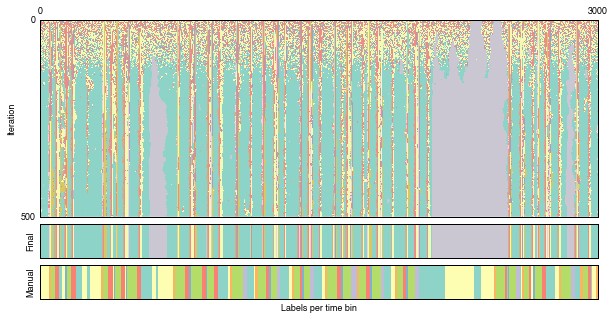

In [13]:
# Plot the true and inferred state sequences
plt_slice = (0, 3000)
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(7,1)

ax3 = fig.add_subplot(gs[-1])
ax1 = fig.add_subplot(gs[:-2])
ax2 = fig.add_subplot(gs[-2])

im = ax1.matshow(perm_stateseq_smpls, aspect='auto', cmap=cmap, vmin=0, vmax=N_used)
ax1.autoscale(False)
ax1.set_xticks([])
ax1.set_yticks([0, N_samples])
ax1.set_ylabel("Iteration")
ax1.set_xlim(plt_slice)
ax1.set_xticks(plt_slice)

ax2.matshow(perm_stateseq_smpls[-1][None,:], aspect='auto', cmap=cmap, vmin=0, vmax=N_used)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylabel("Final")
ax2.set_xlim(plt_slice)

ax3.matshow(worm_datas[worm_to_plot].zimmer_states[None,:], aspect='auto', cmap=cmap, vmin=0, vmax=len(colors)-1)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_ylabel("Manual")
ax3.set_xlabel("Labels per time bin")
ax3.set_xlim(plt_slice)

# plt.savefig(os.path.join(results_dir, "discrete_state_samples.pdf"))

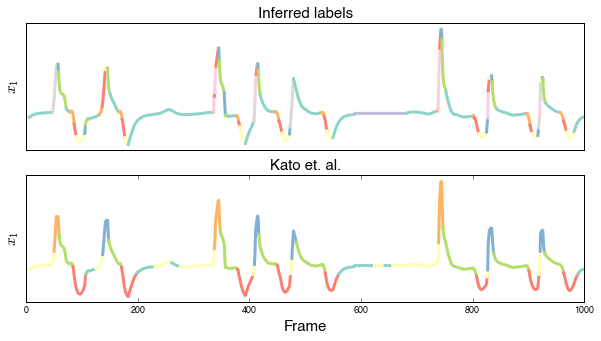

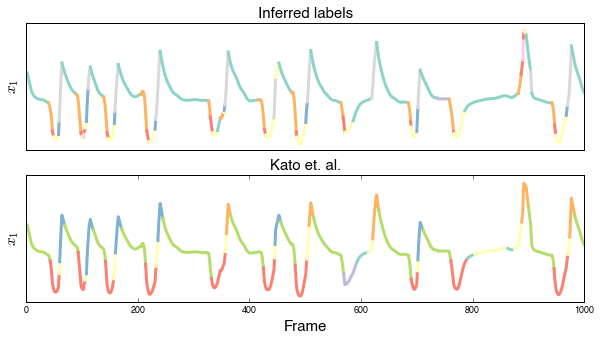

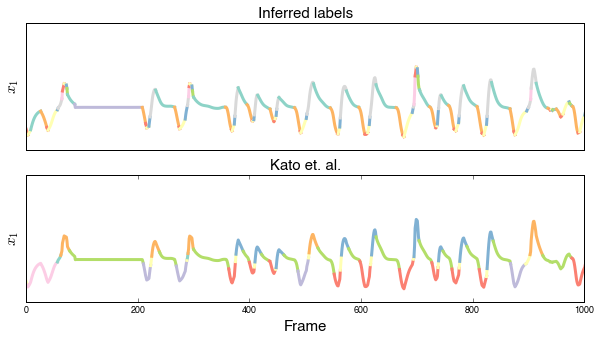

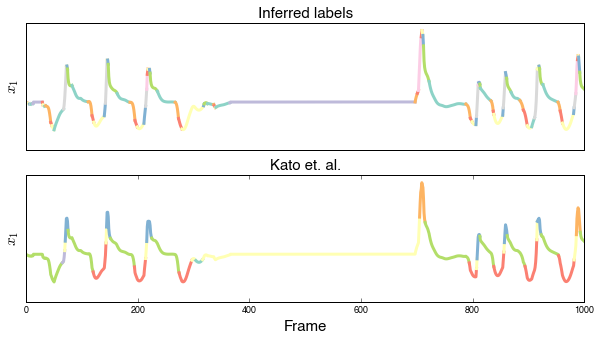

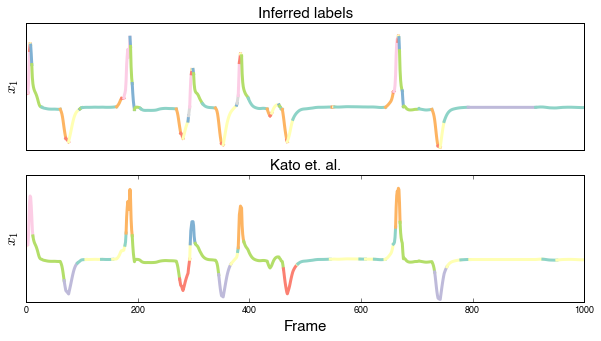

In [25]:
import zimmer.plotting
imp.reload(zimmer.plotting)
from zimmer.plotting import plot_1d_continuous_states

for worm_to_plot in range(N_worms):
    plot_1d_continuous_states(xs[worm_to_plot],
                              zs[worm_to_plot],
                              worm_datas[worm_to_plot].zimmer_states,
                              x_index=0,
                              colors=colors,
                              results_dir=results_dir, 
                              filename="xs_1d_worm{}_dim{}".format(worm_to_plot, 0))



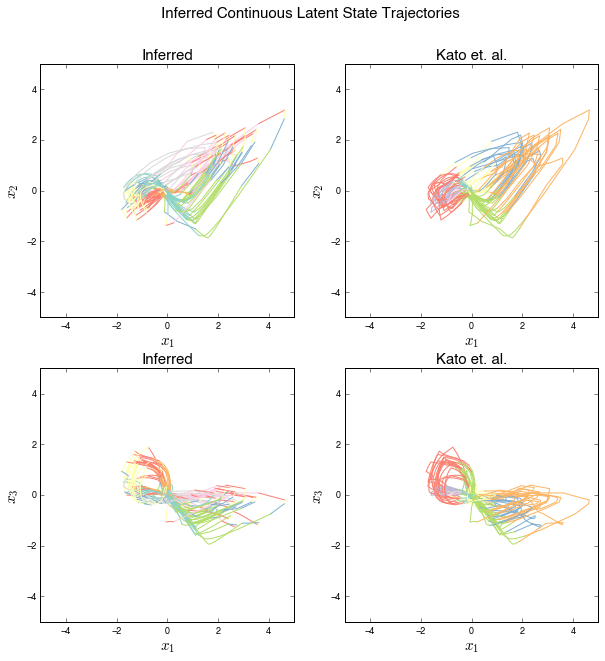

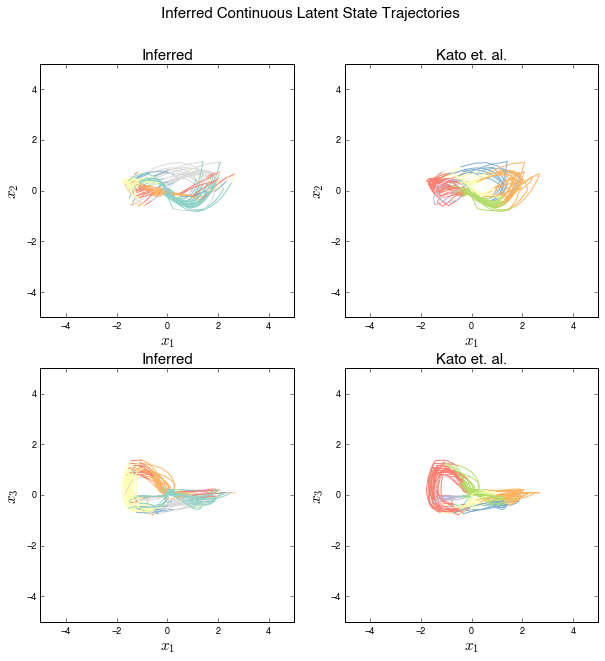

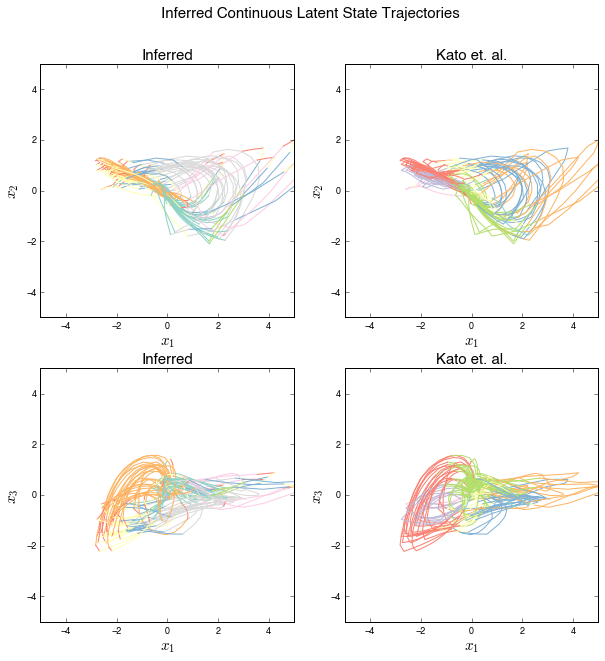

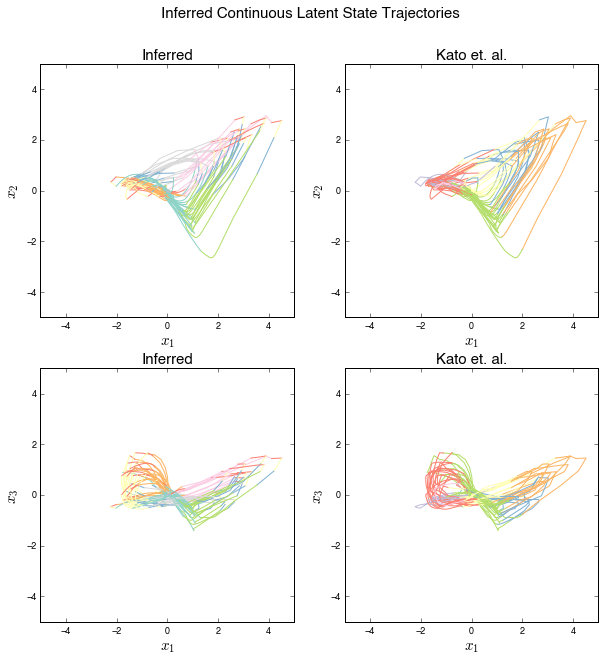

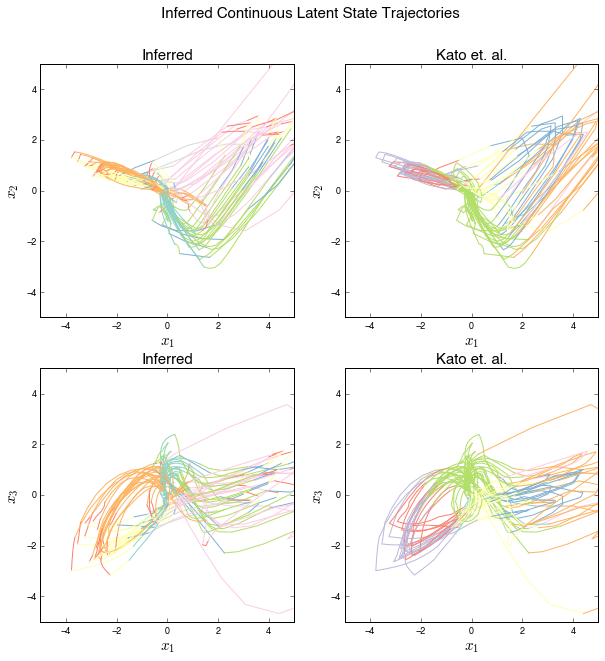

In [29]:
# Plot the inferred latent state sequence
import zimmer.plotting
imp.reload(zimmer.plotting)
from zimmer.plotting import plot_2d_continuous_states

for worm_to_plot in range(N_worms):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(221)
    plot_2d_continuous_states(ax, xs[worm_to_plot], zs[worm_to_plot], colors, inds=(0,1))
    plt.title("Inferred", fontsize=15)
    plt.xlabel("$x_1$", fontsize=15)
    plt.xlim(-5,5)
    plt.ylabel("$x_2$", fontsize=15)
    plt.ylim(-5,5)

    ax = fig.add_subplot(222)
    plot_2d_continuous_states(ax, xs[worm_to_plot], worm_datas[worm_to_plot].zimmer_states, colors, inds=(0,1))
    plt.title("Kato et. al.", fontsize=15)
    plt.xlabel("$x_1$", fontsize=15)
    plt.xlim(-5,5)
    plt.ylabel("$x_2$", fontsize=15)
    plt.ylim(-5,5)

    ax = fig.add_subplot(223)
    plot_2d_continuous_states(ax, xs[worm_to_plot], zs[worm_to_plot], colors, inds=(0,2))
    plt.title("Inferred", fontsize=15)
    plt.xlabel("$x_1$", fontsize=15)
    plt.xlim(-5,5)
    plt.ylabel("$x_3$", fontsize=15)
    plt.ylim(-5,5)

    ax = fig.add_subplot(224)
    plot_2d_continuous_states(ax, xs[worm_to_plot], worm_datas[worm_to_plot].zimmer_states, colors, inds=(0,2))
    plt.title("Kato et. al.", fontsize=15)
    plt.xlabel("$x_1$", fontsize=15)
    plt.xlim(-5,5)
    plt.ylabel("$x_3$", fontsize=15)
    plt.ylim(-5,5)

    fig.suptitle("Inferred Continuous Latent State Trajectories", fontsize=15)

    plt.savefig(os.path.join(results_dir, "xs_2d_worm{}.pdf".format(worm_to_plot)))


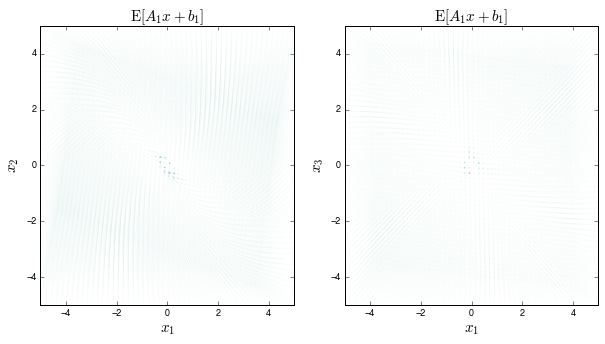

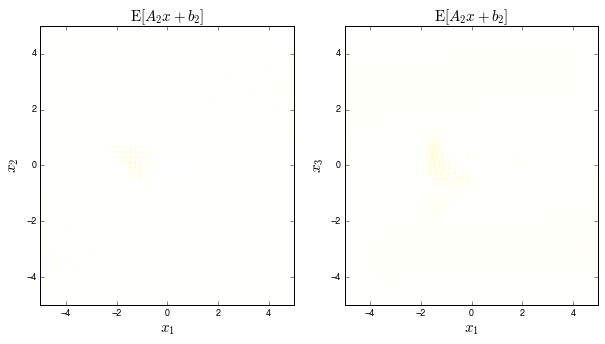

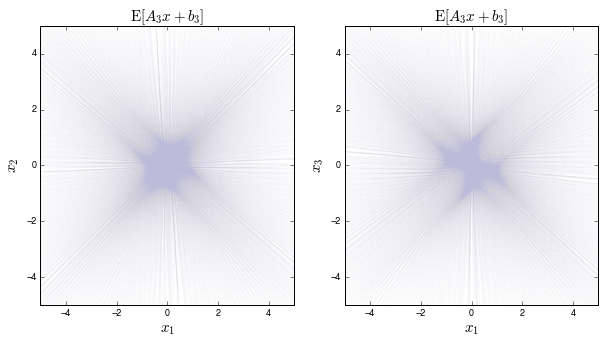

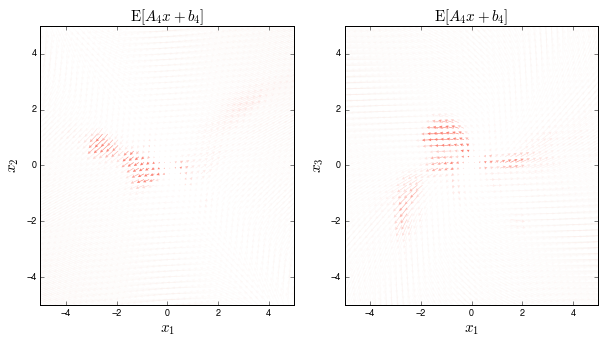

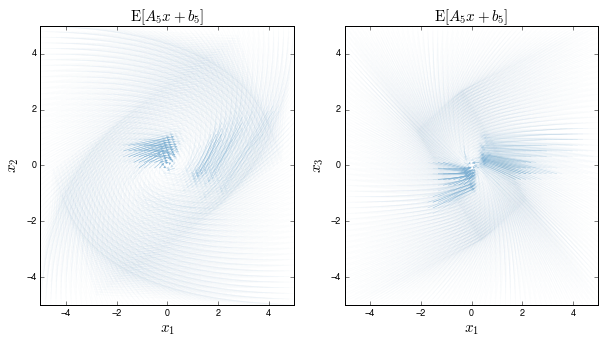

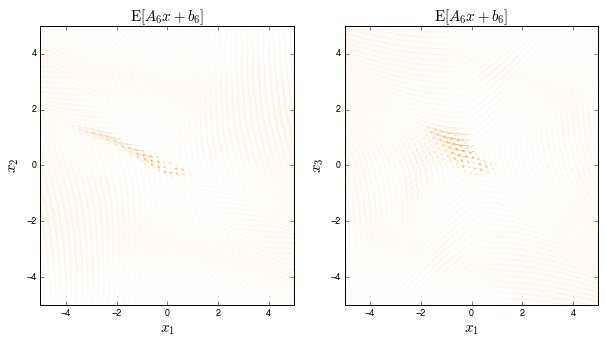

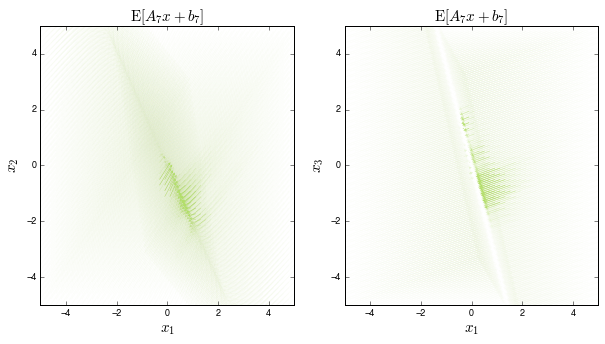

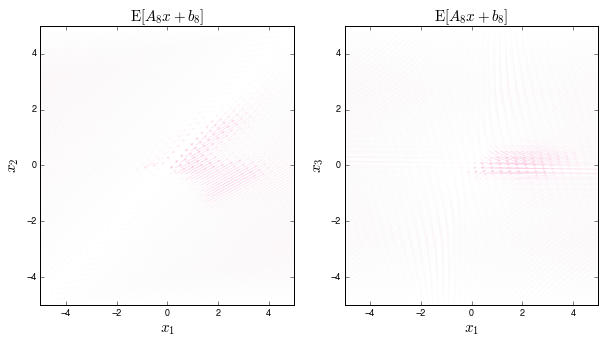

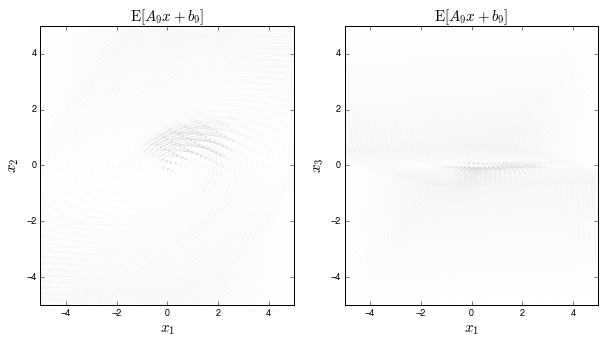

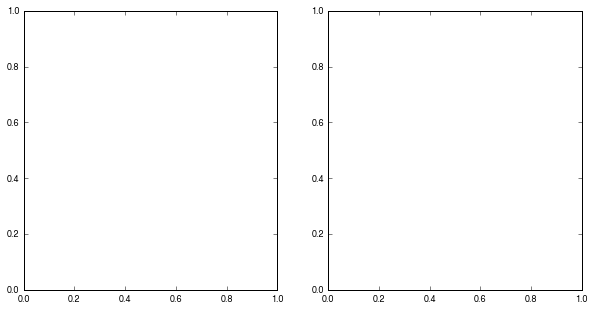

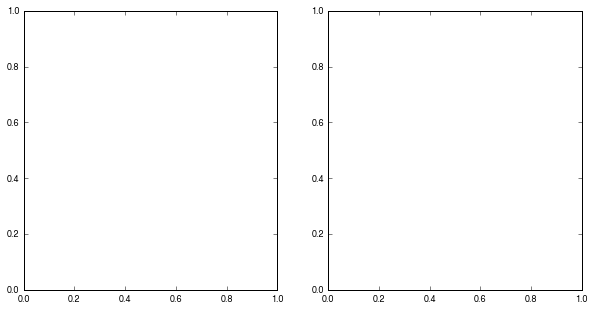

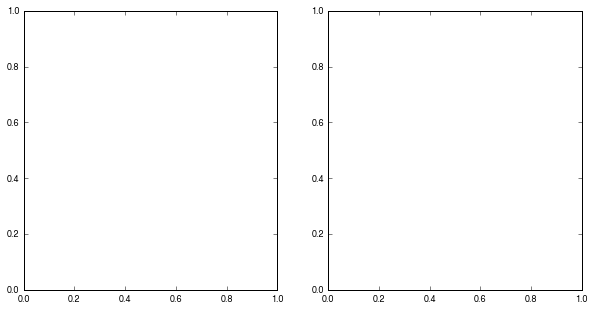

In [27]:
# Plot the vector field showing inferred (discrete-state-dependent)
# dynamics at each point in continuous latent space.
import zimmer.plotting
imp.reload(zimmer.plotting)
from zimmer.plotting import plot_vector_field

for kk in range(N_used):
    plt.figure(figsize=(10,5))
    ax1 = plt.subplot(121)
    plot_vector_field(ax1, perm_dynamics_distns, 
                      np.concatenate(zs, axis=0),
                      np.concatenate(xs, axis=0),
                      np.concatenate(sigma_xs, axis=0),
                      kk, 
                      inds=(0,1), color=np.array(colors[kk] + (1.0,)), 
                      title="$\\mathrm{E}[A_{%d} x + b_{%d}]$" % (kk+1, kk+1),
                     )
    ax2 = plt.subplot(122)
    plot_vector_field(ax2, 
                      perm_dynamics_distns, 
                      np.concatenate(zs, axis=0),
                      np.concatenate(xs, axis=0),
                      np.concatenate(sigma_xs, axis=0), 
                      kk, 
                      inds=(0,2), color=np.array(colors[kk] + (1.0,)),
                      title="$\\mathrm{E}[A_{%d} x + b_{%d}]$" % (kk+1, kk+1))

    plt.savefig(os.path.join(results_dir, "vector_field_{}.pdf".format(kk)))

/Users/scott/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 16196 but corresponding boolean dimension is 3137


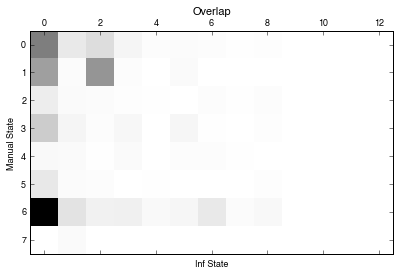

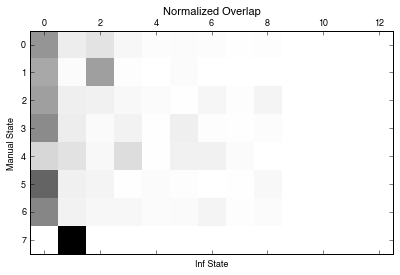

In [28]:
# Visualize the manual-inferred state overlap
N_zimmer = 8
overlap = np.zeros((N_zimmer, N_used+1))
inf_states1 = np.concatenate(zs)
for kk in range(N_zimmer):
    overlap[kk] = np.bincount(inf_states1[zimmer_states==kk], minlength=N_used+1)

normalized_overlap = overlap / (1e-3+overlap.sum(1, keepdims=True))

plt.matshow(overlap, cmap="Greys")
plt.xlabel("Inf State")
plt.ylabel("Manual State")
plt.title("Overlap")

plt.matshow(normalized_overlap, cmap="Greys")
plt.xlabel("Inf State")
plt.ylabel("Manual State")
plt.title("Normalized Overlap")